# 2. Preprocessing
## 2.01 Variable selection

### Linear correlation

We want to shortly investigate which features might carry the most potential for use in the flood model. 
In order to do this, we evaluate the correlation between a the upstream mean of an ERA5 variable or a derived variable against discharge at an example river gridpoint.
Thus, we are comparing time series of predictor variables with timeseries of the predictand.


**Feature engineering** is the process of dimensionality reduction and complexity reduction while preserving most of the information contained in the raw dataset. 
Dimensionality reduction means that we want to eliminate unnecessary features by inspecting the correlation within the set of features to see which features are linearly dependent from another, i.e. can by expressed by other variables.

To estimate the feature importance without running a forecast model, we only consider days with measurable amounts of precipitation recorded and correlate the inputs with the change of discharge from one day to another, instead of absolute values.

### Steps
We
1. load the dataset,
2. visualize the spatial domain,
3. prepare the functions to build the correlation matrices, and
4. run the code for three time periods of 5 years each to see if the correlations change.

We measure the pearson correlation coefficient. 
The point of interest is `latitude=48.35, longitude=13.95`, the most downstream point in the domain, situated in upper Austria.

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

To be able to import custom functions, we need to add the repository path to the system's python path with `sys.path.append('../../')`.

In [2]:
import sys
sys.path.append('../../')

In [3]:
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables, reshape_scalar_predictand

In [20]:
poi = dict(latitude=48.35, longitude=13.95)
# load data
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

Note: `rtp_500-850` is the **relative topography**, a derived variable by subtracting the geopotential in 850 hPa from the geopotential height in 500 hPa, i.e. `era5['z'].sel(level=500)-era5['z'].sel(level=850)`. It is proportional to the mass weighted (=barometric) mean temperature between those levels.

## The dataset domain and the upper danube catchment
Note the cyan circle surrounding the gridpoint from where the time series of river discharge is taken from.

Text(0.5, 1.0, 'mean discharge in the dataset domain')

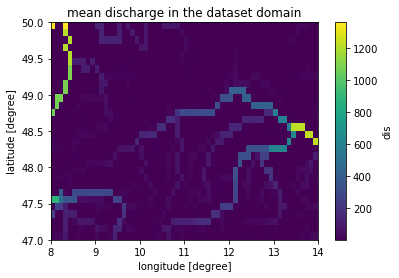

In [21]:
dis_mean = glofas['dis'].mean('time')
dis_mean.plot()
plt.title('mean discharge in the dataset domain')

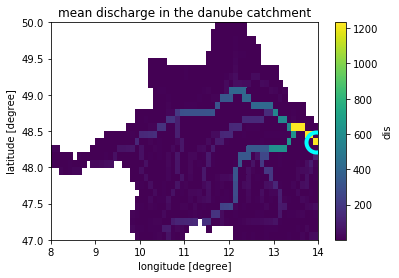

In [23]:
dummy = glofas['dis'].isel(time=0).drop('time')
danube_catchment = get_mask_of_basin(dummy, kw_basins='Danube')
dis_mean.where(danube_catchment).plot()
plt.title('mean discharge in the danube catchment')
plt.gca().plot(poi['longitude'], poi['latitude'], color='cyan', marker='o', 
               markersize=20, mew=4, markerfacecolor='none')

### Prepare the feature array X and predictand y
For easier use, let's define the preparation routine here.

In [5]:
def feature_preproc(era5, glofas, timeinit, timeend):

    features = ['cp', 'lsp', 'ro', 'rtp_500-850', 'tcwv', 'swvl1']
    era5_features = era5[features]

    # interpolate to glofas grid
    era5_features = era5_features.interp(latitude=glofas.latitude,
                                         longitude=glofas.longitude)
    # time subset
    era5_features = era5_features.sel(time=slice(timeinit, timeend))
    glofas = glofas.sel(time=slice(timeinit, timeend))

    # select the point of interest
    # poi = dict(latitude=48.403, longitude=15.615)  # krems (lower austria), outside the test dataset
    poi = dict(latitude=48.35, longitude=13.95)  # point in upper austria

    dummy = glofas['dis'].isel(time=0)
    danube_catchment = get_mask_of_basin(dummy, kw_basins='Danube')
    X = era5_features.where(danube_catchment).mean(['latitude', 'longitude'])

    # select area of interest and average over space for all features
    dis = glofas.interp(poi)
    y = dis.diff('time', 1)  # compare predictors to change in discharge
    
    shifts = range(1,3)
    notshift_vars = ['swvl1', 'tcwv', 'rtp_500-850']
    shift_vars = [v for v in X.data_vars if not v in notshift_vars]

    X = add_shifted_variables(X, shifts, variables=shift_vars)
    
    Xda, yda = reshape_scalar_predictand(X, y)  # reshape into dimensions (time, feature)
    return Xda, yda

### Prepare the correlation matrix calculation
For convenience, let's define the correlation calculation procedure here.

In [6]:
import seaborn as sns

def generate_heatmap(X, y, descr='description'):
    df = pd.DataFrame(data=X.values, columns=X.features.values, index=X.time.values)
    df['predictand'] = y
    plt.figure(figsize=(25,25))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    cor_predictand = abs(cor['predictand'])
    feature_importance = cor_predictand[cor_predictand > 0.2]
    print(descr)
    print(feature_importance)
    return feature_importance

Now that all methods are set up, lets have a look at different time periods and generate a correlation heatmap between all features, with a printed list of features >0.2 correlation coeff at the end. Lets also save the important feature into a new list and evaluate it at the end.

In [7]:
important_features = []

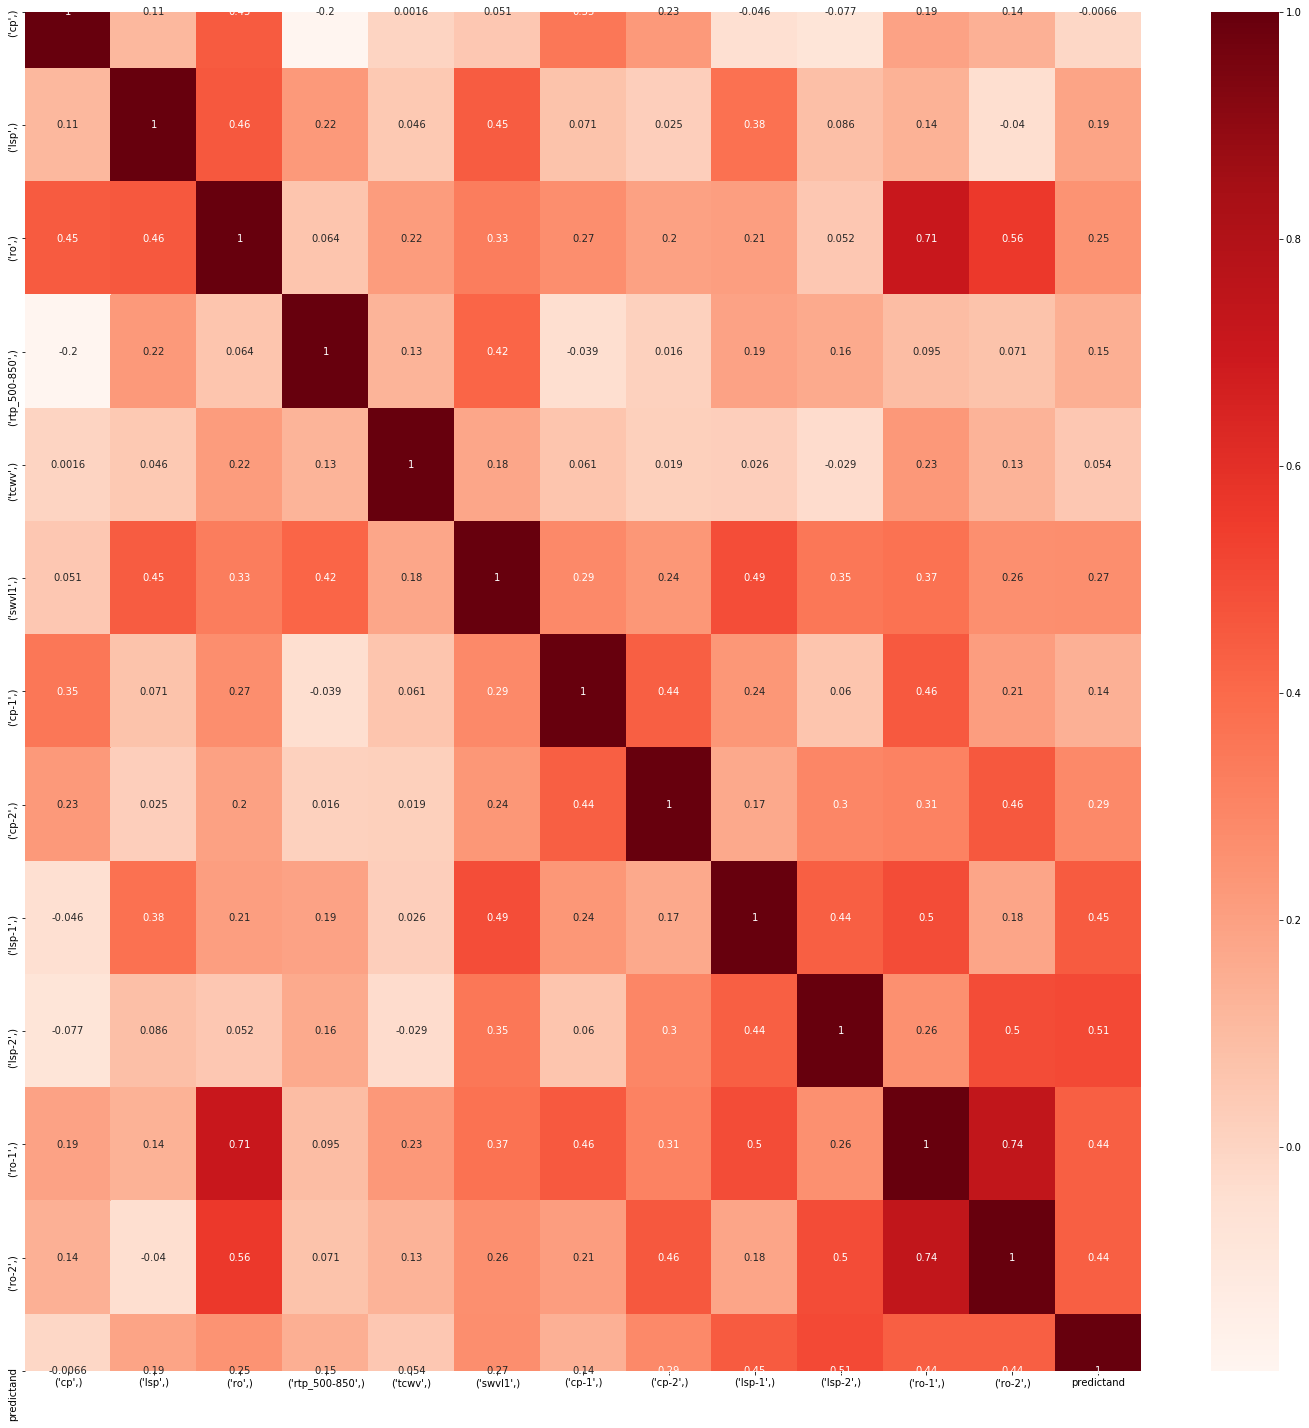

1980-1984; only days with precip > 1mm
(ro,)         0.247870
(swvl1,)      0.267278
(cp-2,)       0.285266
(lsp-1,)      0.450470
(lsp-2,)      0.507095
(ro-1,)       0.435793
(ro-2,)       0.437846
predictand    1.000000
Name: predictand, dtype: float64


In [8]:
timeinit, timeend = '1980', '1984'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)

Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)

ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


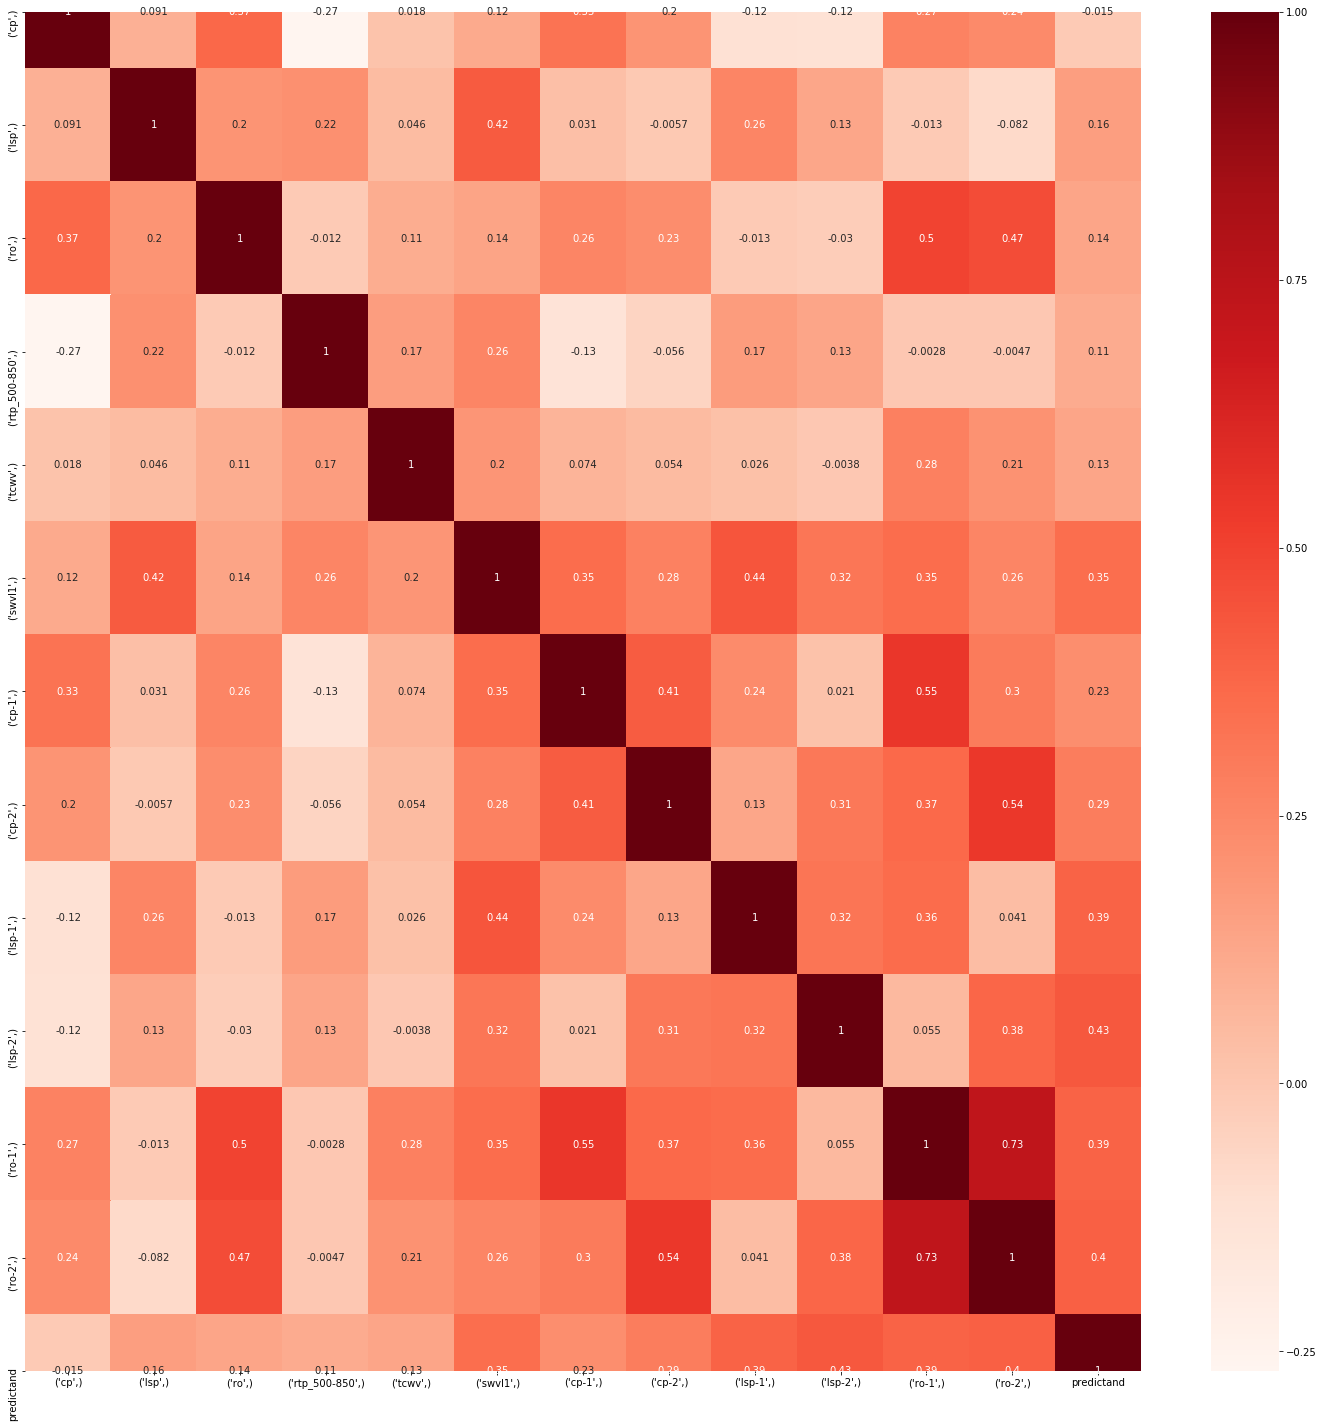

1985-1989; only days with precip > 1mm
(swvl1,)      0.346954
(cp-1,)       0.226712
(cp-2,)       0.287686
(lsp-1,)      0.389427
(lsp-2,)      0.427370
(ro-1,)       0.387354
(ro-2,)       0.396332
predictand    1.000000
Name: predictand, dtype: float64


In [9]:
timeinit, timeend = '1985', '1989'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)

Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)

ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

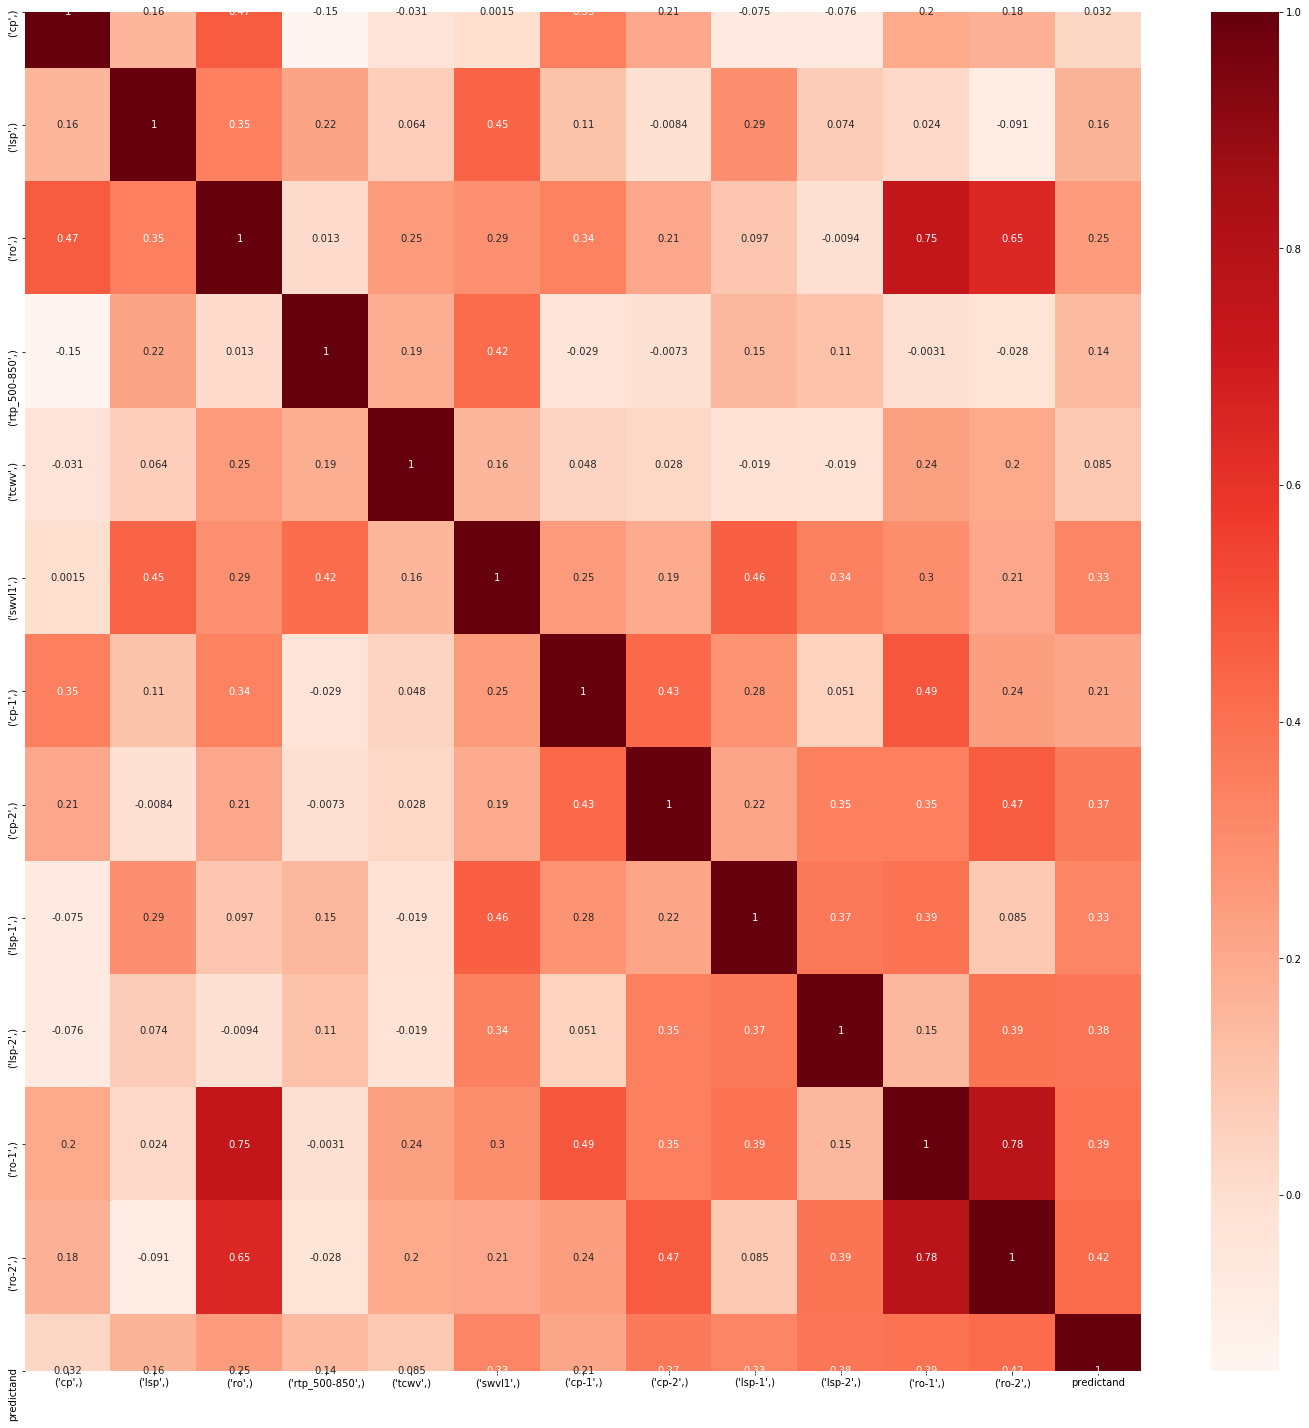

1990-1995; only days with precip > 1mm
(ro,)         0.249801
(swvl1,)      0.328639
(cp-1,)       0.213713
(cp-2,)       0.369377
(lsp-1,)      0.328067
(lsp-2,)      0.382326
(ro-1,)       0.392958
(ro-2,)       0.417626
predictand    1.000000
Name: predictand, dtype: float64


In [10]:
timeinit, timeend = '1990', '1995'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))

Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

In [30]:
for entry in important_features:
    print(entry[:-1].sort_values(ascending=False))
    print('#'*30)

(lsp-2,)    0.507095
(lsp-1,)    0.450470
(ro-2,)     0.437846
(ro-1,)     0.435793
(cp-2,)     0.285266
(swvl1,)    0.267278
(ro,)       0.247870
Name: predictand, dtype: float64
##############################
(lsp-2,)    0.427370
(ro-2,)     0.396332
(lsp-1,)    0.389427
(ro-1,)     0.387354
(swvl1,)    0.346954
(cp-2,)     0.287686
(cp-1,)     0.226712
Name: predictand, dtype: float64
##############################
(ro-2,)     0.417626
(ro-1,)     0.392958
(lsp-2,)    0.382326
(cp-2,)     0.369377
(swvl1,)    0.328639
(lsp-1,)    0.328067
(ro,)       0.249801
(cp-1,)     0.213713
Name: predictand, dtype: float64
##############################


We can notice a few things here:
- No variable is much more important than any other in this list
- From the heatmaps, total column water vapor (tcwv) and especially convective precipitation at the same day as the discharge are very low correlated to discharge.
- runoff is highly correlated to itself with a lag of one day.
- the same applies for tcwv and rtp_500-850 (seen below).

Lastly, we look at a specific flooding example: May/June 2013

In [13]:
timeinit = '2013-05-30'
timeend = '2013-06-15'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)

Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)

ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')

As the sample dataset does not include 2013, this image can only be created using the full dataset. This image was created with the full dataset which also includes a lot more variables.

![Flooding-case-2013](correlation_2013.png)

In [12]:
ft[ft > 0.2]

(ro,)         0.249801
(swvl1,)      0.328639
(cp-1,)       0.213713
(cp-2,)       0.369377
(lsp-1,)      0.328067
(lsp-2,)      0.382326
(ro-1,)       0.392958
(ro-2,)       0.417626
predictand    1.000000
Name: predictand, dtype: float64

As can be seen, the resulting features take on a different take. It is not suprising, that **cp** is not contained in the stricter requirement of coef > 0.6, because at the event in question, there was largerly orographically induced precipitation (so called, Nordstau), which is contributed as **lsp**.

Additionally, **tcwv-1** and **tcwv-2** exhibit a hight correlation coefficient as well. But looking at inter-feature colinearity, we can quickly deduce that both of those variables are highly correlated with **lsp** as well (which makes perfect sense from a physical pov, due to the orographic induced lifting, moisturizing the atmosphere over extended periods of time), which means we can safely ignore those features, as their impact is already considered in **lsp**.

Although the other features exhibit not insignificant colinearity as well, they do present a different physical process, which is why they should not be neglected just because of one examplary case.

Going forward, the most interesting features to capture for flooding seem to be **lsp**, **ro**, **swvl1** as well as time lagged **lsp** (an indication for large flooding events, due to extending periods with huge amounts of precipitation, as well as **cp** for flash floods (although this last relation has to be captured in a few case examples yet, but holds some weight in the overall influence shown above).